In [3]:
import pickle
import math
import torch
import scipy
import random
import seaborn as sns
import numpy as np
import random
from scipy import spatial
from matplotlib import pyplot as plt
from collections import Counter, defaultdict
from cca_core import get_cca_similarity, robust_cca_similarity, sum_threshold
sns.set_context("talk")


setups = [("size", [125, 100, 75, 50, 25, 10, 5]),
          ("dropout", [0.1, 0.25, 0.5, 0.65, 0.75, 0.85, 0.9]),
          ("beta", [2.5e-5, 0.000625, 0.00125, 0.0025, 0.00625, 0.0125, 0.025])]

## 1. Compare predictions to predictions of baseline

In [4]:
def load_hidden(filename, model):
    sentences, labels, test_pred, = pickle.load(open(filename + model, 'rb'))[:3]
    return [torch.argmax(p, dim=-1) for p in test_pred]


blue = sns.color_palette("crest_r", 3)[0]
purple = sns.color_palette("flare_r", 3)[0]

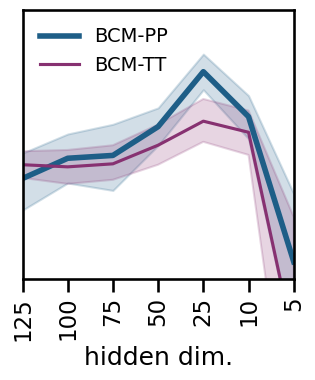

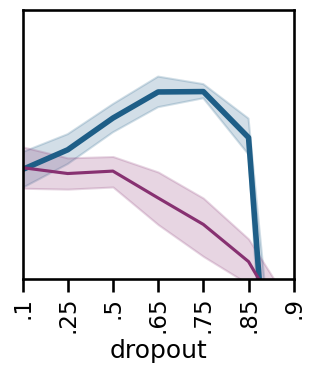

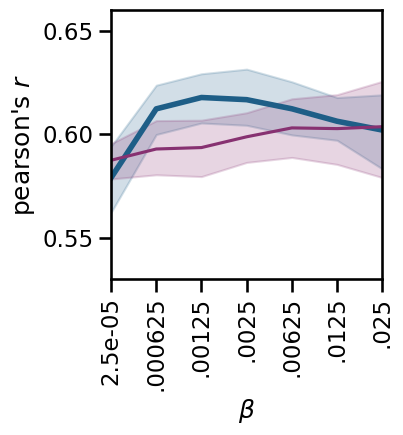

In [6]:
for setup, weights in setups:
    x, y, x2, y2 = [], [], [], []
    for seed in range(1, 11):
        for i, weight in enumerate(weights):
                if setup == "beta":
                    weight *= 4
                prd1 = load_hidden(f"../../tree_lstms/checkpoints_old/sentiment/baseline_seed={seed}",
                                   f"/test_beta=0.0.pickle")
                prd2 = load_hidden(f"../../tree_lstms/checkpoints_old/sentiment/treelstm_bottleneck_seed={seed}/setup=regular",
                              f"/test_{setup}={weight}.pickle")
                r, p = scipy.stats.pearsonr(prd1, prd2)
                x.append(i)
                y.append(r)

                prd1 = load_hidden(f"../../tree_lstms/checkpoints_old/sentiment/baseline_seed={seed}",
                                   f"/test_taught_beta=0.0.pickle")
                prd2 = load_hidden(f"../../tree_lstms/checkpoints_old/sentiment/treelstm_bottleneck_seed={seed}/setup=regular",
                              f"/test_taught_{setup}={weight}.pickle")
                r, p = scipy.stats.pearsonr(prd1, prd2)
                x2.append(i)
                y2.append(r)

    plt.figure(figsize=(3.5, 3.5))   
    ax = sns.lineplot(x=x, y=y, linewidth=4, label="BCM-PP", color=blue)
    ax = sns.lineplot(x=x2, y=y2, color=purple, label="BCM-TT")
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels([str(l).replace("0.", ".") for l in weights], rotation=90)        
    plt.ylim(0.53, 0.66)
    plt.xlabel(setup.replace("beta", r"$\beta$").replace("size", "hidden dim."))
    if setup != "beta":
        plt.yticks([])
        plt.ylabel("")
    else:
        plt.ylabel(r"pearson's $r$")
    if setup == "size":
        plt.legend(fontsize=14, frameon=False)
    else:
        plt.legend([],[], frameon=False)
    plt.xlim(0, 6)
    plt.savefig(f"figures/correlation_baseline_{setup}.pdf", bbox_inches="tight")
    plt.show()

## 2. Compare ranking to rankings of baseline

In [17]:
from utils import measure_distance

def load_data(weights, dataset="test", setup="beta", mode="baseline", threshold=25, cca=False,
              taught=False):
    def load_hidden(filename, model):
        sentences, labels, test_pred, _, hidden = pickle.load(
            open(filename + model, 'rb'))
        return sentences, np.array(hidden)

    all_similarities = []
    for seed in range(1, 11):
        for weight in weights:
            prefix = f"../../tree_lstms/checkpoints_old/sentiment/treelstm_bottleneck_seed={seed}/setup=regular"
            if mode == "baseline_to_base":
                _, baseline = load_hidden(prefix, f"/{dataset}_beta=0.0.pickle")
                if taught:
                    sentences, hidden_states = load_hidden(
                        f"../../tree_lstms/checkpoints_old/sentiment/baseline_seed={seed}", f"/{dataset}_taught_beta=0.0.pickle")
                else:
                    sentences, hidden_states = load_hidden(
                    f"../../tree_lstms/checkpoints_old/sentiment/baseline_seed={seed}", f"/{dataset}_beta=0.0.pickle")
                similarities = measure_distance(baseline, hidden_states, cca, threshold)
            else:
                _, baseline = load_hidden(prefix, f"/{dataset}_beta=0.0.pickle")
                if taught:
                    sentences, hidden_states = load_hidden(
                        prefix, f"/{dataset}_taught_{setup}={weight}.pickle")
                else:
                    sentences, hidden_states = load_hidden(
                        prefix, f"/{dataset}_{setup}={weight}.pickle")
                similarities = measure_distance(baseline, hidden_states, cca, threshold)
            all_similarities.append(similarities)

    scores = np.array(all_similarities).mean(axis=0)
    mini = min(scores)
    maxi = max(scores)
    scores = [(x - mini) / (maxi - mini) for x in scores]
    return sentences, scores

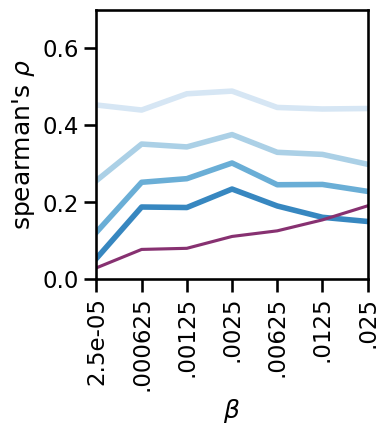

In [23]:
for setup, weights in setups[-1:]:
    x, y, x2, y2, hue = [], [], [], [], []
    for threshold in [100, 75, 50, 25]:
        for i, weight in enumerate(weights):
            sentences, similarities1 = load_data(
                weights=[weight*4], setup=setup, mode="regular", dataset='val',
                cca=True, threshold=threshold)
            baseline_similarities = load_data(
                weights=[weight], setup=setup, mode="baseline_to_base", dataset='val',
                cca=True, threshold=threshold)[1]
            rho, _ = scipy.stats.spearmanr(similarities1, baseline_similarities)
            x.append(i)
            y.append(rho)
            hue.append(threshold)

            if threshold == 100:
                sentences, similarities2 = load_data(
                    weights=[weight*4], setup=setup, mode="regular", dataset='val',
                    cca=False, taught=True)
                baseline_similarities = load_data(
                    weights=[weight], setup=setup, mode="baseline_to_base", dataset='val',
                    cca=False, taught=True)[1]
                rho, _ = scipy.stats.spearmanr(similarities2, baseline_similarities)
                x2.append(i)
                y2.append(rho)

    plt.figure(figsize=(3.5, 3.5))
    ax = sns.lineplot(x=x, y=y, hue=hue, palette=sns.color_palette("Blues", 5)[:4], linewidth=4)
    ax = sns.lineplot(x=x2, y=y2, color=purple, label="TRE training")
    ax.set_xticks([0, 1, 2, 3, 4, 5, 6])
    ax.set_xticklabels([str(l).replace("0.", ".") for l in weights], rotation=90)        

    plt.xlabel(setup.replace("beta", r"$\beta$").replace("size", "hidden dim."))
    if setup != "beta":
        plt.yticks([])
        plt.ylabel("")
    else:
        plt.ylabel(r"spearman's $\rho$")
    if setup == "size":
        h, l = ax.get_legend_handles_labels()
        ax.legend(h[:4], l[:4], fontsize=14, frameon=True, bbox_to_anchor=(0.5, 0.5))
    else:
        plt.legend([],[], frameon=False)
    plt.ylim(0, 0.7)
    plt.xlim(0, 6)
    plt.savefig(f"figures/correlation_blranking_{setup}.pdf", bbox_inches="tight")
    plt.show()